## Importing Libraries

In [1]:
! pip install gdown
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding
import seaborn as sns
sns.set_theme()
import pandas as pd
pd.set_option('display.max_colwidth', -1)

  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=d91987807bea7937c6ad4fb18ba9046d4e0449925d70b95ad97d56220656421d
  Stored in directory: /root/.cache/pip/wheels/3d/ec/b0/a96d1d126183f98570a785e6bf8789fca559853a9260e928e1
Successfully built gdown


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


## Getting our dataset

### METHOD1: Making the dataset from txt file

Downloading dataset from google drive and unzipping it

In [2]:
# !gdown --id 1D3yt99D0GcCRCbdKbUQGxbqjkeh91hTg
# !unrar x /content/hamshahri.rar
# !unzip /content/hamshahriold/Corpus/Hamshahri-Corpus.zip
# !unzip /content/hamshahriold/Corpus/PersianStopWords.zip

In [3]:
# stop_words = []
# with open("PersianStopWords.txt", "r", encoding="utf-8") as stopwords_retriever:
#   for line in stopwords_retriever:
#     word = line.strip()
#     stop_words.append(word)

# stopwords_retriever.close()

Writing data rows to a list

In [4]:
# !pip install hazm
# from __future__ import unicode_literals
# from hazm import *

In [5]:
# row = ["","","",""]
# rows = []
# is_first = True
# with open("Hamshahri-Corpus.txt", "r", encoding="utf-8") as corpus_reader:
#   for line in corpus_reader:
#     stripped_line = line.strip()
#     if stripped_line == "":
#         continue
            
#     else: 
#         if (stripped_line.startswith(".DID")):
#             if is_first:
#                 is_first = False
#             else:
#                 # Removing stopwords from rows in each iteration
#                 row[3] = [word for word in word_tokenize(row[3]) if word not in stop_words]
#                 row[3] = [x for x in row[3] if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
#                 row[3] = ' '.join(row[3])
#                 rows.append(row)
#                 row = ["","","",""]
#             row[0] = stripped_line.split(".DID\t", 1)[1]
#         elif (stripped_line.startswith(".Date")):
#             row[1] = stripped_line.split(".Date\t", 1)[1]
#         elif (stripped_line.startswith(".Cat")):
#             row[2] = stripped_line.split(".Cat\t", 1)[1]
#         else:
#             row[3] += stripped_line + " "
    
# corpus_reader.close()

#### Making a CSV file from rows list

In [6]:
# import csv

# header = ['DID', 'Date', 'Cat', 'News']

# with open('corpus.csv', 'w', encoding='utf-8', newline='') as corpus_writer:
#     writer = csv.writer(corpus_writer)

#     # write the header
#     writer.writerow(header)

#     # write multiple rows
#     writer.writerows(rows)

# corpus_writer.close()

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cp -r "/content/corpus.csv" "/content/drive/MyDrive/corpus.csv"

### METHOD2: Using premade CSV file

In [8]:
!gdown --id 1w4-vTNQ4sXLBcXqG7TCjhNEtQg3cveiH


/opt/conda/lib/python3.7/site-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1w4-vTNQ4sXLBcXqG7TCjhNEtQg3cveiH
To: /kaggle/working/corpus.csv
100%|█████████████████████████████████████████| 426M/426M [00:01<00:00, 369MB/s]


## Reading dataset with pandas library

In [9]:
df = pd.read_csv("corpus.csv")
df.set_index('DID', inplace=True)
df.drop_duplicates(keep='last', inplace=True) 

getting number of Categories

In [10]:
print("We have a total of {} categories".format(df['Cat'].nunique()))
df['Cat'].value_counts()
number_of_unique_cat = df['Cat'].nunique()

We have a total of 105 categories


## Plotting the categories

In [11]:
categories = dict(df['Cat'].value_counts())
categories_with_small_counts = dict(df['Cat'].value_counts().tail(92))
for i in list(categories_with_small_counts):
  if (i in categories_with_small_counts.keys()):
     categories.pop(i, None)

In [12]:
categories.update({"Others":df['Cat'].value_counts().tail(92).sum()})

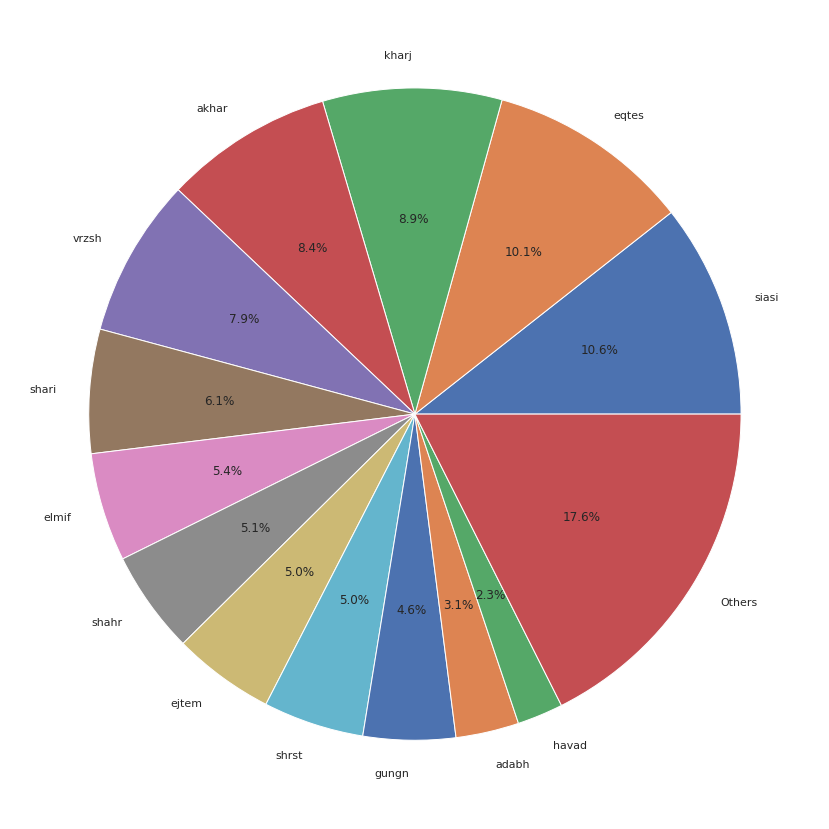

In [13]:
fig = plt.figure(figsize=(15,15))
plt.pie(categories.values(), 
        labels=categories.keys(),
        autopct='%1.1f%%');

## Making our train, validation and test data

In [14]:
X,Y = df['News'],df['Cat']
X_train, X_val, y_train, y_val = train_test_split(X,pd.get_dummies(Y), test_size=0.2, random_state = 40)
X_val, X_test , y_val, y_test= train_test_split(X_val,y_val, test_size=0.5, random_state = 40)
X_train = X_train.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)

In [15]:
vocab_size =20000
max_length = 300
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

## Tokenizing and Padding

In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_train = np.asarray(y_train)
# y_train = pd.get_dummies(y_train)

X_val = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(X_val,maxlen= max_length,padding=padding_type, truncating=trunc_type)
y_val = np.asarray(y_val)
# y_val = pd.get_dummies(y_val)

train_set = np.array(X_train)
val_set = np.array(X_val)

train_label = np.array(y_train)
val_label = np.array(y_val)


# y_test = pd.get_dummies(y_test)
y_test = np.asarray(y_test)
y_test = np.argmax(y_test,axis=1)   #this would be our ground truth label while testing

print(train_set.shape)
print(train_label.shape)


print(val_set.shape)
print(val_label.shape)


num_tokens = len(tokenizer.word_index.items()) + 2
embedding_dim = 50

(132175, 300)
(132175, 105)
(16522, 300)
(16522, 105)
